In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def earth_model(rock_props):
    """Builds a earth model using input Vp-Density pairs and calculates reflection coefficients and layer impedance.

    Parameters
    ----------
    rock_props : list
        A list of len 6 containing Vp-Density pairs for the three layers

    Returns
    -------
    rc : ndarray
        Numpy ndarray containing reflection coefficients
    imp : ndarray
        Numpy ndarray containing layer impedance

    """
    # define the earth model
    width, height = 101, 240
    model = 1 + np.tri(height, width, -height // 3, dtype=int)
    model[: height // 3, :] = 0

    # reshape the input rock properties list for populating earth model
    rocks = np.array(rock_props).reshape(3, 2)

    # use fancy indexing to create an earth model where each layer of the model
    # has Vp & Density at each location
    earth = rocks[model]

    # calculate the acoustic impedance of each layer
    imp = np.apply_along_axis(np.product, -1, earth)

    # calculate the reflection coefficients for the interfaces between each layer
    rc = np.zeros(imp.shape, dtype=float)
    rc[1:, :] = (imp[1:, :] - imp[:-1, :]) / (imp[1:, :] + imp[:-1, :])

    return rc, imp

In [5]:
def wavelet(duration=0.100, dt=0.001, w_type=0, f=None):
    """This function defines a wavelet to convolve with the earth model reflection coefficients

    Parameters
    ----------
    duration : float
        length in seconds of wavelet
    dt : float
        sample increment of wavelet
    w_type : int
        Wavelet type. 0 is Ricker, 1 is Ormsby
    f : list
        dominant frequency of wavelet

    Returns
    -------
    ndarray
        wavelet amplitude

    """
    if f is None:
        f = [25]
    t = np.linspace(-duration / 2, (duration - dt) / 2, int(duration / dt))
    if w_type:
        # Ormsby wavelet
        f1, f2, f3, f4 = [x for x in f]
        a = ((np.pi * f4)**2)/((np.pi * f4) - (np.pi * f3))
        b = ((np.pi * f3)**2)/((np.pi * f4) - (np.pi * f3))
        c = ((np.pi * f2)**2)/((np.pi * f2) - (np.pi * f1))
        d = ((np.pi * f1)**2)/((np.pi * f2) - (np.pi * f1))
        w = (((a * (np.sinc(f4 * t))**2) - (b * (np.sinc(f3 * t))**2)) -
             ((c * (np.sinc(f2 * t))**2) - (d * (np.sinc(f1 * t))**2)))
    else:
        # Ricker wavelet
        f = f[0]
        w = (1.0 - 2.0 * (np.pi ** 2) * (f ** 2) * (t ** 2)) * np.exp(
            -(np.pi ** 2) * (f ** 2) * (t ** 2)
        )
    return np.squeeze(w) / np.amax(w)

In [6]:
def tuning_wedge(rc, w):
    """Calculates synthetic tuning wedge based on reflection coefficients and wavelet

    Parameters
    ----------
    rc : ndarray
        ndarray of reflection coefficients
    w : ndarray
        wavelet

    Returns
    -------
    ndarray
        ndarray of synthetic tuning wedge

    """
    synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode="same"), axis=0, arr=rc)
    return synth

In [7]:
rock_props = [3000, 2.5, 2700, 2.3, 3000, 2.5]

In [8]:
rc, imp = earth_model(rock_props)

In [9]:
wvlt = wavelet()

In [10]:
synth = tuning_wedge(rc, wvlt)

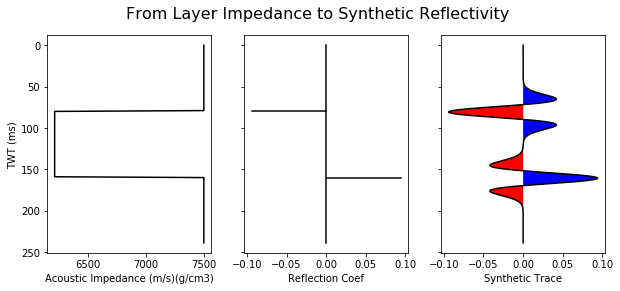

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,4))

fig.suptitle('From Layer Impedance to Synthetic Reflectivity', fontsize=16)

y = np.zeros(imp.shape[0])
y[1:] += 0.001
y = np.cumsum(y) * 1000

ax[0].plot(imp[:,80], y, c='k')
ax[0].invert_yaxis()
ax[0].set_xlabel('Acoustic Impedance (m/s)(g/cm3)')
ax[0].set_ylabel('TWT (ms)')

#ax[1].stem(rc[:,80], y, use_line_collection=True)
ax[1].plot(np.zeros(y.shape), y, c='k')
ax[1].plot([np.nanmin(rc[:,80]), 0], [np.argmin(rc[:,80]), np.argmin(rc[:,80])], c='k')
ax[1].plot([0, np.nanmax(rc[:,80])], [np.argmax(rc[:,80]), np.argmax(rc[:,80])], c='k')
ax[1].set_xlabel('Reflection Coef')

ax[2].plot(synth[:,80], y, c='k')
ax[2].fill_betweenx(y, 0, synth[:,80], where=synth[:,80]>=0, facecolor='blue', interpolate=True)
ax[2].fill_betweenx(y, 0, synth[:,80], where=synth[:,80]<=0, facecolor='red')
ax[2].set_xlabel('Synthetic Trace')

plt.savefig('../pyseistuned/static/img/layerAI_rc_synth.png', dpi=300, edgecolor='k')

In [259]:
wt = np.zeros(imp.shape[1])
wt[1:] += 0.001
wt = np.cumsum(wt) * 1000

dx = int(round(((np.max(wt) - np.min(wt))/imp.shape[1])*5))
imp_min = imp.min()
imp_max = imp.max()
imp_diff = imp_max - imp_min

In [260]:
dx

5

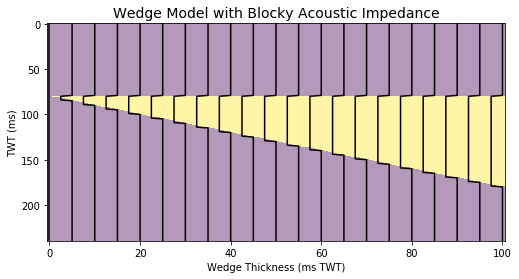

In [261]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
for i, trace in enumerate(imp.transpose()[::dx, :]):
    tr = (((trace - imp_max)/imp_diff))*dx*0.5
    x = i*dx
    ax.plot((x + tr), y, 'k')
ax.imshow(imp, cmap='viridis_r', alpha=0.4, aspect=0.2)
ax.set_xlabel('Wedge Thickness (ms TWT)')
ax.set_ylabel('TWT (ms)')
ax.set_title('Wedge Model with Blocky Acoustic Impedance', fontsize=14)
#plt.show()
plt.savefig('../pyseistuned/static/img/wedge_model_w_blocky_impedance.png', dpi=300, edgecolor='k')

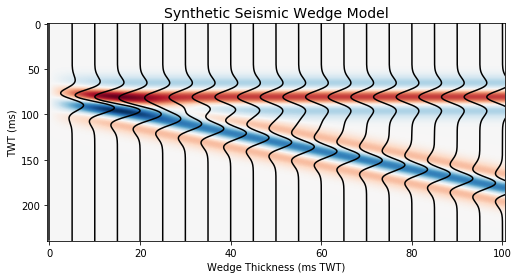

In [265]:
syn_min = synth.min()
syn_max = synth.max()
d_syn = syn_max - syn_min

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
for i, trace in enumerate(synth.transpose()[::dx, :]):
    tr = (((trace - syn_min)/d_syn) - 0.5)*2*dx
    x = 0 + i*dx
    ax.plot((x + tr), y, 'k')
ax.imshow(synth, cmap='RdBu', aspect=0.2, interpolation='bilinear')
ax.set_xlabel('Wedge Thickness (ms TWT)')
ax.set_ylabel('TWT (ms)')
ax.set_title('Synthetic Seismic Wedge Model', fontsize=14)
#plt.show()
plt.savefig('../pyseistuned/static/img/synthetic_wedge_model.png', dpi=300, edgecolor='k')